# Project: Analysing NYC High School Data
---

In [5]:
# Importing libraries used throughout this lession

# for display more than one pandas df at once
# from IPython.display import display 
# import re # for regular expressions
# import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 

## Overview:
---
This project extends from the exercises 3.3.1 - 3.3.3. With Sections 1 and 2 coming from 3.3.1 and 3.3.2 hence the comments are lacking. In general, this project is analysing NYC school results (SAT) data.


[GitHub repo for this lesson solutions](https://github.com/dataquestio/solutions/blob/master/Mission217Solutions.ipynb)


---

## 1. Reading Data
---

### 1.1 Reading .csv Data

In [6]:
# list of file names
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# dictionary for storing pandas df
data = {}

# reading csv files as pandas and storing in data dict
for file in data_files:
    df = pd.read_csv("data/schools/{0}".format(file))
    df_name = file.replace(".csv", "")  # dictionary key
    data[df_name] = df

# Renaming hs_directory df dbn column to DBN to match after dfs
data['hs_directory'] = data['hs_directory'].rename(columns={'dbn': 'DBN'}) 

### 1.2 Reading Survey .txt Data and Selecting Relevant Data

In [7]:
# reading in .txt file in as pandas df 
survey_all = pd.read_csv('data/schools/survey_all.txt', 
                                 delimiter="\t", 
                                 encoding="windows-1252"
                        )

survey_d75 = pd.read_csv('data/schools/survey_d75.txt',
                                    delimiter="\t",
                                    encoding="windows-1252"
                        )

# combining survey dataframes about the row axis
survey = pd.concat([survey_all, survey_d75], axis=0)

# Re-naming dbn column to DBN to match .csv file names
survey = survey.rename(columns={'dbn': 'DBN'}) 

# List of relevant rows
survey_cols = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", 
               "N_p", "saf_p_11", "com_p_11", "eng_p_11", 
               "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", 
               "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", 
               "aca_s_11", "saf_tot_11", "com_tot_11", 
               "eng_tot_11", "aca_tot_11"]

# Selecting only the columns of interest
survey = survey.loc[:, survey_cols]

# adding survey df to data dict
data["survey"] = survey

## 2. Cleaning Data
---

### 2.1 Creating DBN Column in class_size df

In [8]:
# creating a series of padded CSD column
padded_CSD = data['class_size']['CSD'].apply(lambda csd: str(csd).zfill(2))

# Creating a DBN series in class_size df by combining 
# the SCHOOL CODE col and padded_CSD series
DBN = padded_CSD + data['class_size']['SCHOOL CODE']

# inserting the DBN identifyer in the first column of class_size df
data['class_size'].insert(0, 'DBN', DBN)

### 2.2 Summing SAT Scores

In [9]:
# list of SAT score columns
SAT_cols = ['SAT Math Avg. Score', 
            'SAT Critical Reading Avg. Score', 
            'SAT Writing Avg. Score'
           ]

# Convert the SAT results in numerical from string data type
for sat in SAT_cols:
    data["sat_results"][sat] = pd.to_numeric(data["sat_results"][sat], 
                                             errors="coerce"
                                            )
    
# Summing SAT scores and creating new column in sat_results
data["sat_results"]["sat_score"] = (data["sat_results"][SAT_cols[0]] +
                                    data["sat_results"][SAT_cols[1]] +
                                    data["sat_results"][SAT_cols[2]]
                                   )

### 2.3 Extracting latitude and Longitude

In [10]:
# RegEx for find coordinates from hs_directory['Location 1']
coord_pattern = r"[-+]?\d*\.\d+"

# simply funciton that using RegEx to get latitude coordinates 
def get_lat(loc: str):
    return re.findall(coord_pattern, loc)[0]

# appling get_lat function to location 1 column of hs_directory df
data['hs_directory']['lat'] = (data['hs_directory']
                               ['Location 1'].apply(get_lat)
                              )

# getting the longitude from location 1 column of 
# hs_directory df using Lamdba instead
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(
                        lambda loc: re.findall(coord_pattern, loc)[1])

# converting coordinate data to numerical
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], 
                                            errors="coerce"
                                           )
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], 
                                            errors="coerce"
                                           )

### 2.4 Condensing Data

In [11]:
# creating series from class_size column
class_size = data['class_size'].copy()

# renameing GRADE column to remove space at end of string
class_size = class_size.rename(columns={'GRADE ': 'GRADE'}) 

# filtering GRADE for '09-12'
class_size = class_size[class_size['GRADE'] == '09-12']

# filtering  PROGRAM TYPE for 'GEN ED'
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']


In [12]:
# Grouping class_size by DBN
class_size = class_size.groupby('DBN').agg('mean', numeric_only=True)

# reset the index inplace a.k.a not creating a new df
class_size.reset_index(inplace=True)

# replace the old class_size df in the data dict with the cleaned one
data["class_size"] = class_size

# filter demographics df from school year for 2011 2012 only
data["demographics"] = (data["demographics"]
                        [data["demographics"]['schoolyear'] == 20112012]
                       )

# Filter graduation, only select rows where the Cohort column equals 2006.
data['graduation'] = (data['graduation']
                      [data['graduation']['Cohort'] == '2006']
                     )

# Filter graduation, only select rows where the Demographic column equals Total Cohort.
data['graduation'] = (data['graduation']
                      [data['graduation']['Demographic'] == 'Total Cohort'])

### 2.5 Converting AP Scores to Numeric

In [13]:
# list of columns that need converter to numerical type
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# check type of columns of interest  
data['ap_2010'][cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   AP Test Takers                        258 non-null    object
 1   Total Exams Taken                     258 non-null    object
 2   Number of Exams with scores 3 4 or 5  258 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


In [14]:
# TURNS OUT THE DATA WAS ALREADY OF TYPE FLOAT, BUT JUST TO SHOWCASE HOW TO DO THIS!

# converting columns in col of ap_2010 df to numerical
# Note errors='coerce' sets invaild parsing to NaN
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce') 

# check type of columns of interest  
data['ap_2010'][cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AP Test Takers                        233 non-null    float64
 1   Total Exams Taken                     233 non-null    float64
 2   Number of Exams with scores 3 4 or 5  151 non-null    float64
dtypes: float64(3)
memory usage: 6.2 KB


### 2.6 Combining Datasets

In [15]:
# merging data on DBN via left merge to keep sat_results data and 
# remove unusable row that are not in sat_results
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# merging data on DBN via inner merge 
combined = combined.merge(data["class_size"], on="DBN", how="inner")
combined = combined.merge(data["demographics"], on="DBN", how="inner")
combined = combined.merge(data["survey"], on="DBN", how="inner")
combined = combined.merge(data["hs_directory"], on="DBN", how="inner")

### 2.7 Fulling Missing Elements

In [16]:
# replacing miss NaN values with the columns mean
means = combined.mean(numeric_only=True) # gets the mean of each column
combined = combined.fillna(means) # replaces NaN elements with column mean

# if there were any remaining NaN due to no mean calculated then replacing with 0
combined = combined.fillna(0) 

### 2.8 Add a School District Column for Mapping

In [17]:
# creating a column of school_dist from first two chars in DBN string
combined['school_dist'] = combined['DBN'].apply(lambda dbn: dbn[0:2])

/var/folders/s5/vk8nxr_94p15g_k3bptwpbjm0000gn/T/ipykernel_95474/613869921.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['school_dist'] = combined['DBN'].apply(lambda dbn: dbn[0:2])


## 3. Analysing Data
---

### 3.1 Finding Correlations

In [18]:
# getting correlations in combined df
correlations = combined.corr(method='pearson', min_periods=1, numeric_only=True)
# top 10 positive correlations to sat_score
print(correlations['sat_score'].nlargest(10, keep='all'))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
Name: sat_score, dtype: float64


In [19]:
# top 10 negative correlations to sat_score
print(correlations['sat_score'].nsmallest(10, keep='all'))

frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
ell_num        -0.153778
lon            -0.132222
lat            -0.121029
com_p_11       -0.115073
male_per       -0.112062
Name: sat_score, dtype: float64


### 3.2 Plotting Survey Correlations

In [20]:
# Remove DBN since it's a unique identifier, 
# not a useful numerical value for correlation.
survey_cols.remove("DBN")

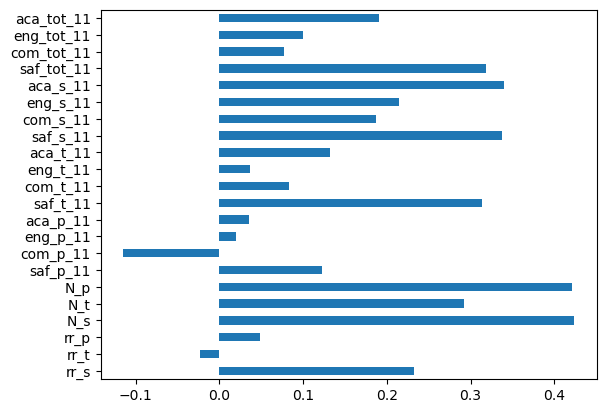

In [21]:
# Using pandas matplotlib methods.
correlations['sat_score'][survey_cols].plot.barh()
# Display the plot
plt.show()

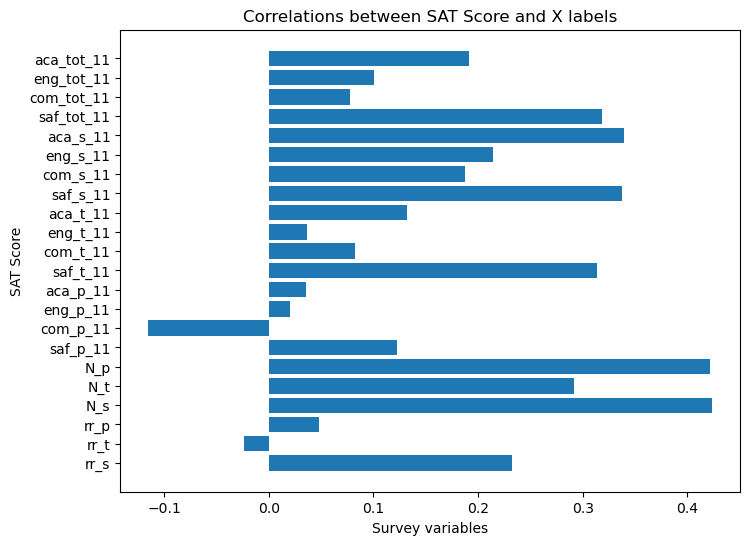

In [22]:
# simply using matplotlib methods directly
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(survey_cols, correlations['sat_score'][survey_cols])
ax.set_title('Correlations between SAT Score and X labels')
ax.set_xlabel('Survey variables')
ax.set_ylabel('SAT Score')
plt.show()

---
**Observations from above graph**

- The is a strong positive correlation between number of student & parent survey repsonses can SAT score - indicating that student & parent participation is important factor in school results; however, the numbers of respondents is also correlated to the enrollment numbers at a school.

- More interesting is the response rates: `rr_p`, `rr_t`, and `rr_s` of parent, teacher, and student respectively. From this responses rates we can see that the student response rate is positive correlated, the parents a little as well. Showing that student enagement correlates to SAT scores. Interestingly, the teacher response rate is negatively correlated, this might be indicating that the teachers that focused their workload on the importance of teaching and not doing extras, like surveys, had their students perform better. This could also indicate that teachers at lower preforming schools are more likely to complete the surveys to provide much need feedback on where the schooling system is failing and vice versa teachers at high preforming schools are not completing the surveys because they don't see a need given from their prospective the schooling system is working. This question is not a part of this project's analysing; however it is still interesting and might be worth a further investigation.

- The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

From the file 'Survey Data Dictionary.xls' the below information on column definitions is given (note _11 is the same _10):

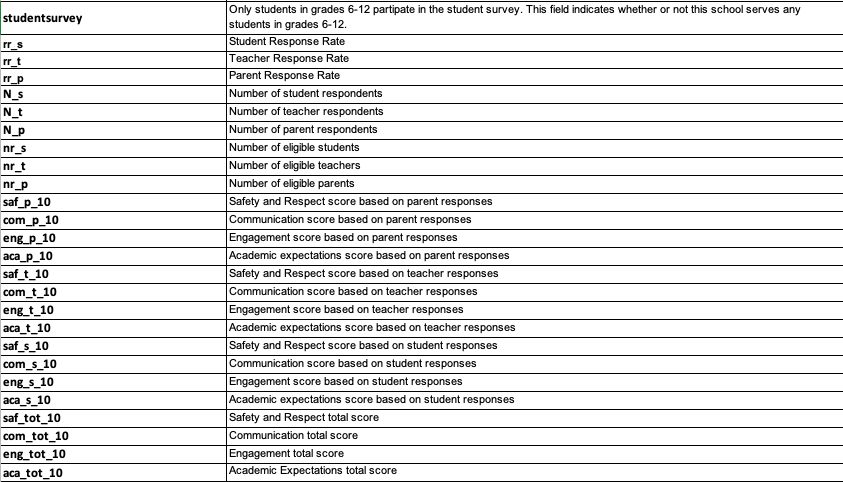


### 3.3 Investigating SAT Score and Teacher/Student Preceived Safety at School

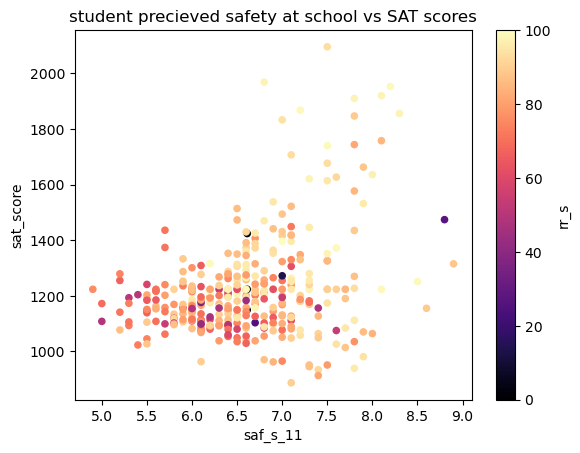

In [23]:
# scatter plot of student precieved safety at school vs SAT scores
combined.plot.scatter(x='saf_s_11', 
                      y='sat_score', 
                      c='rr_s',
                      colormap='magma',
                      title='student precieved safety at school vs SAT scores')
plt.show()

---
**Observations from above graph**

The appears to be a weak correlation between SAT score and precieved safety from students. However, from the colourmap which shows rate of student responses to the survey, there appears to be a correlation between resposne rate and precieved safety. There also appears to be a correlation between response rate and SAT score.

---

### 3.4 Borough Safety

In [24]:
# Calculating the average precieved safety per borough
boros = combined.groupby("boro")["saf_s_11"].mean()
boros

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

In [25]:
combined["saf_s_11"].describe()

count    363.000000
mean       6.611667
std        0.699706
min        4.900000
25%        6.100000
50%        6.600000
75%        7.100000
max        8.900000
Name: saf_s_11, dtype: float64

---
**Observations from above graph**

Student precieved safety by borough are all quite similar. The mean of student precieved safety is 6.6 with a std deviation about 10% from the mean (0.69) show there is little differnce from norm. However, in responses there is a range of  4 - see below.

---

In [26]:
np.ptp(combined["saf_s_11"])

4.0

### 3.5 Exploring Race and SAT Scores

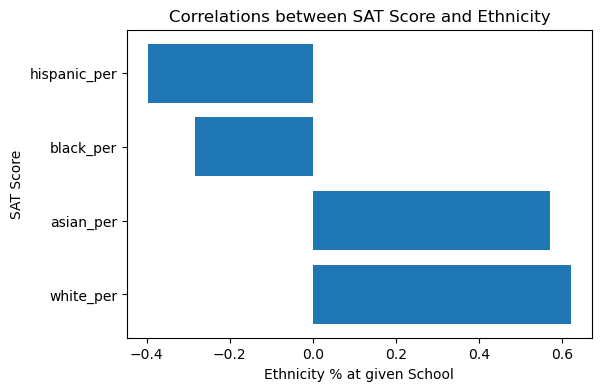

In [27]:
# simply using matplotlib methods directly
ethnicity = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(ethnicity, correlations['sat_score'][ethnicity])
ax.set_title('Correlations between SAT Score and Ethnicity')
ax.set_xlabel('Ethnicity % at given School')
ax.set_ylabel('SAT Score')
plt.show()

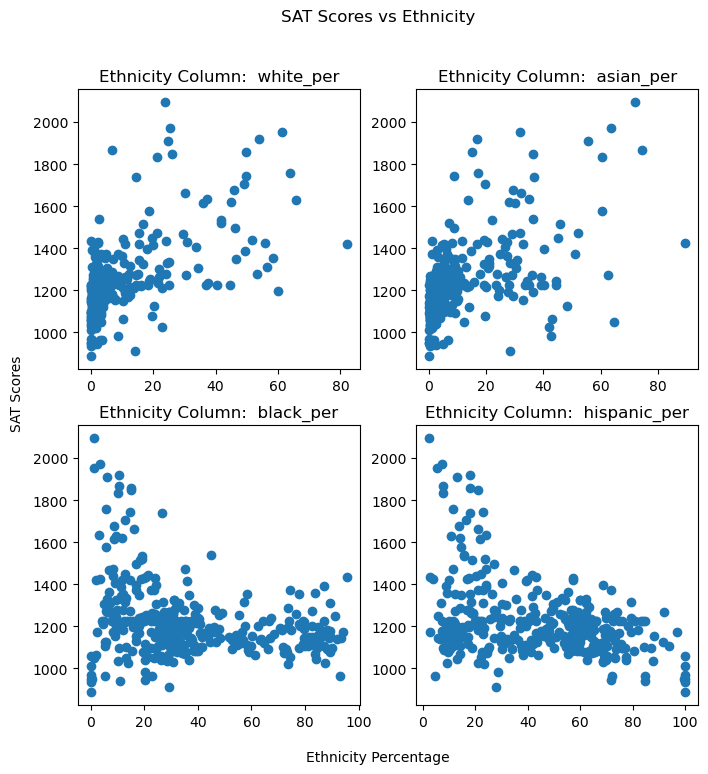

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = [ax1, ax2, ax3, ax4]

for ax, race in zip(axes, ethnicity):
    ax.scatter(combined[race], combined['sat_score'])
    ax.set_title(f'Ethnicity Column:  {race}')

# Set global x-axis label
fig.text(0.5, 0.04, 'Ethnicity Percentage', ha='center')
# Set global y-axis label
fig.text(0.04, 0.5, 'SAT Scores', va='center', rotation='vertical')

# Add a main title to the figure
fig.suptitle('SAT Scores vs Ethnicity')
plt.show()

---
**Observations from above graph**

There is a positive correlation between the increase precentage of white and asian students and SAT scores and the inverse for black and hispanic students.

---

In [29]:
# Schools with hispanic_percentage greater than 95%
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

---
**Observations from above graph**

The schools listed above have many students learning English and have a high number of students who recetnly immigranted to the US, which could explain the lower SAT scores. This also so that the SAT system is not well suited to people in this situation and as a result may/will likely impact their career prospects later on.

---

In [30]:
# Schools with hispanic_percentage less than 10 and SAT scores greater than 1800
combined[(combined["hispanic_per"] < 10) & 
         (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

---
**Observations from above graph**

The schools listed above seems to specilise in STEM as a result they recieve extra funding. They also only allow students who pass an entrance exam. This could explain the high SAT scores, but does not complete explain the low hispanic percentage. It may be possible that in the NYC area and wider New York state hispanic people are more like to have recently immigrated making it difficult to pass the entrance exam.

---

### 3.6 Exploring Gender and SAT Scores

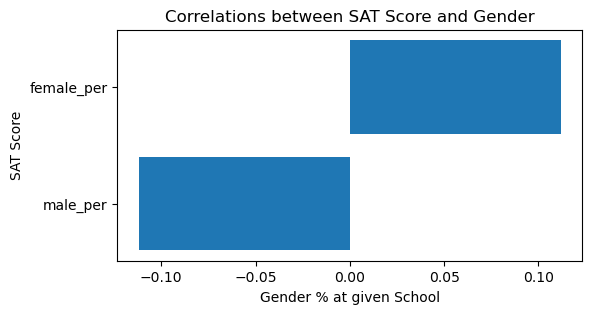

In [31]:
# simply using matplotlib methods directly

# Note gender from this dataset is old and 
# unfortunately does not include gender diversity
gender = ['male_per', 'female_per']

fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(gender, correlations['sat_score'][gender])
ax.set_title('Correlations between SAT Score and Gender')
ax.set_xlabel('Gender % at given School')
ax.set_ylabel('SAT Score')
plt.show()

---
**Observations from above graph**

There is a clear positive correlation between the female student precentage at a school and SAT scores. The opposite is true for the male student precentage

---

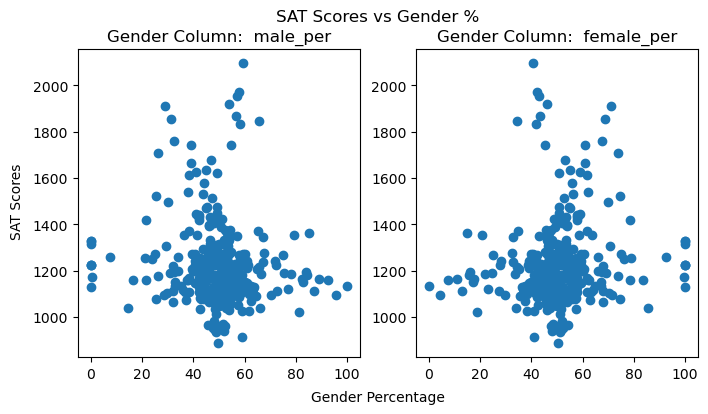

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes = [ax1, ax2]

for ax, gender in zip(axes, gender):
    ax.scatter(combined[gender], combined['sat_score'])
    ax.set_title(f'Gender Column:  {gender}')

# Set global x-axis label
fig.text(0.5, 0.0, 'Gender Percentage', ha='center')
# Set global y-axis label
fig.text(0.04, 0.5, 'SAT Scores', va='center', rotation='vertical')

# Add a main title to the figure
fig.suptitle('SAT Scores vs Gender %')
plt.show()


---
**Observations from above graph**

There is no real correlation between SAT score and gender. As the genders are only binary their scatter plots mirror one and other. It does a appear that a high female student precentage has an increase in SAT score overview; however, this appear minimal and may be a result of a statistic from the year and not a long term trend.

---

In [33]:
# listing schools with a high female student precentage and high state scores
combined[(combined["female_per"] > 60) & 
         (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

---
**Observations from above graph**

These schools have a high level of liberal arts

---

### 3.7 Exploring AP Score vs. SAT Score

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. This section will explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [34]:
# Frist removing the blank space at the end of AP Test Takers column name
combined = combined.rename(columns={'AP Test Takers ': 'AP Test Takers'}) 

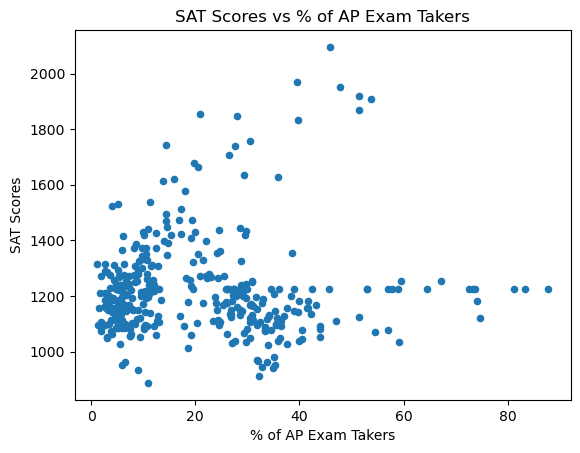

In [35]:
# Calculating the precentage of student in each that took an AP exam
combined['ap_per'] = (combined['AP Test Takers'] / combined['total_enrollment']) * 100

# scatter plot of relationship between % of AP takers and SAT score
combined.plot.scatter(x='ap_per', y='sat_score')
plt.title('SAT Scores vs % of AP Exam Takers')
plt.xlabel('% of AP Exam Takers')
plt.ylabel('SAT Scores')
plt.show()

---
**Observations from above graph**

There doesn't appear to be a high correlation between SAT scores and precentage of students taking an AP exam at a given school. However, there does appear to be a clear folking of no correlation and a positive correlcations. Showing that there may be a correlaton at some school but not others. 

---